In [1]:
from spacerocks.spacerock import SpaceRock, RockCollection
from spacerocks.observing import Observatory, DetectionCatalog
from spacerocks.spice import SpiceKernel
from spacerocks.time import Time
from spacerocks.nbody import Simulation, Integrator

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
kernel.load("/Users/kjnapier/data/spice/de440s.bsp")

In [2]:
ARCSEC_PER_RAD = 206264.80624709636

In [3]:
epoch = Time.now()
planets_names = ["sun", 
                "mercury barycenter"]#,
                #  "venus barycenter",
                #  "earth",
                #  "mars barycenter",
                #  "jupiter barycenter", 
                #  "saturn barycenter", 
                #  "uranus barycenter", 
                #  "neptune barycenter"]

planets = [SpaceRock.from_spice(name, epoch, frame="ECLIPJ2000", origin="ssb") for name in planets_names]

In [4]:
sim = Simulation()

sim.set_epoch(epoch)
sim.set_frame("ECLIPJ2000")
sim.set_origin("ssb")

for planet in planets:
    sim.add(planet)
    
sim.move_to_center_of_mass()

In [5]:
mercury = sim.perturbers[1]
mercury.calculate_orbit()

evec_0 = np.array(mercury.evec) / np.linalg.norm(mercury.evec)

In [6]:
dts = np.linspace(0, 365.25 * 10_000, 10_000)
epochs = [epoch + dt for dt in dts]

In [7]:
perturber_snapshots = []

for epoch in epochs:
    sim.integrate(epoch)
    perturber_snapshots.append(sim.perturbers)

In [8]:
mercury = sim.perturbers[1]
mercury.calculate_orbit()

evec_1 = np.array(mercury.evec) / np.linalg.norm(mercury.evec)

In [9]:
np.arccos(np.dot(evec_0, evec_1)) * ARCSEC_PER_RAD

506562.2592881859

In [10]:
for p in perturber_snapshots:
    p.calculate_orbit()

In [11]:
c = 173.14463348
mu = mercury.mu
a = mercury.a
e = mercury.e
T = 2 * np.pi * np.sqrt(a**3 / mu)

In [12]:
print(a, e, T)

0.38635162660475975 0.2042687563159187 87.71472544006967


In [13]:
rads_per_rev = 24 * np.pi**3 * a**2 / (T**2 * c**2 * (1 - e**2))

(2460363.6249074074, 6112863.616835382)

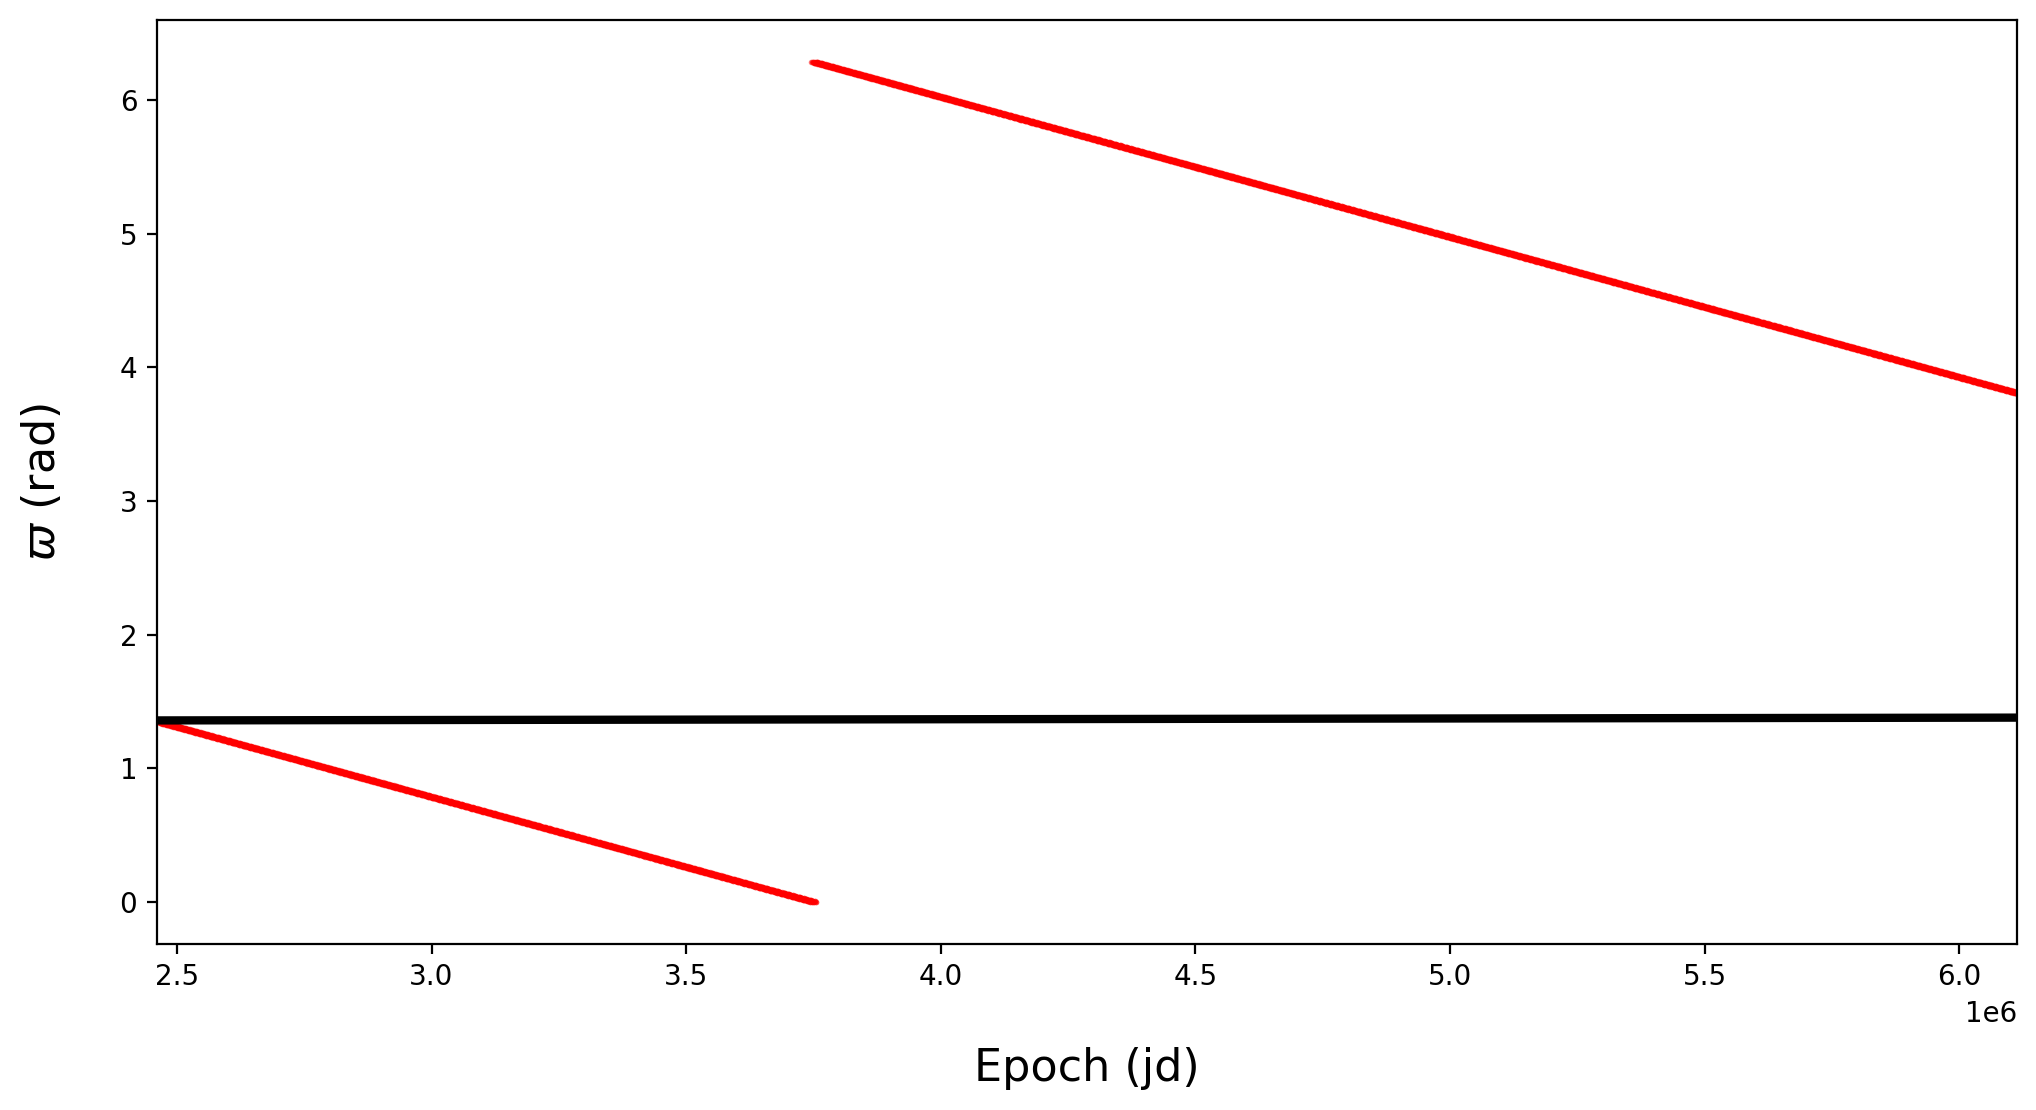

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
varpis = [p.varpi[1] for p in perturber_snapshots]
epochs = [p[1].epoch.epoch for p in perturber_snapshots]

n_rev = (np.array(epochs) - epochs[0]) / T
prediction = varpis[0] + rads_per_rev * n_rev
    

ax.scatter(epochs, varpis, s=1, alpha=0.5, label='Simulation', color='red')
ax.plot(epochs, prediction, color='black', lw=3, label='Theory')

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel(r'$\varpi$ (rad)', fontsize=16, labelpad=20)
ax.set_xlim(epochs[0], epochs[-1])
#ax.set_ylim(0, 2 * np.pi)

In [15]:
px, py, pz = np.ravel([p.x for p in perturber_snapshots]), np.ravel([p.y for p in perturber_snapshots]), np.ravel([p.z for p in perturber_snapshots])

(-0.7, 0.7)

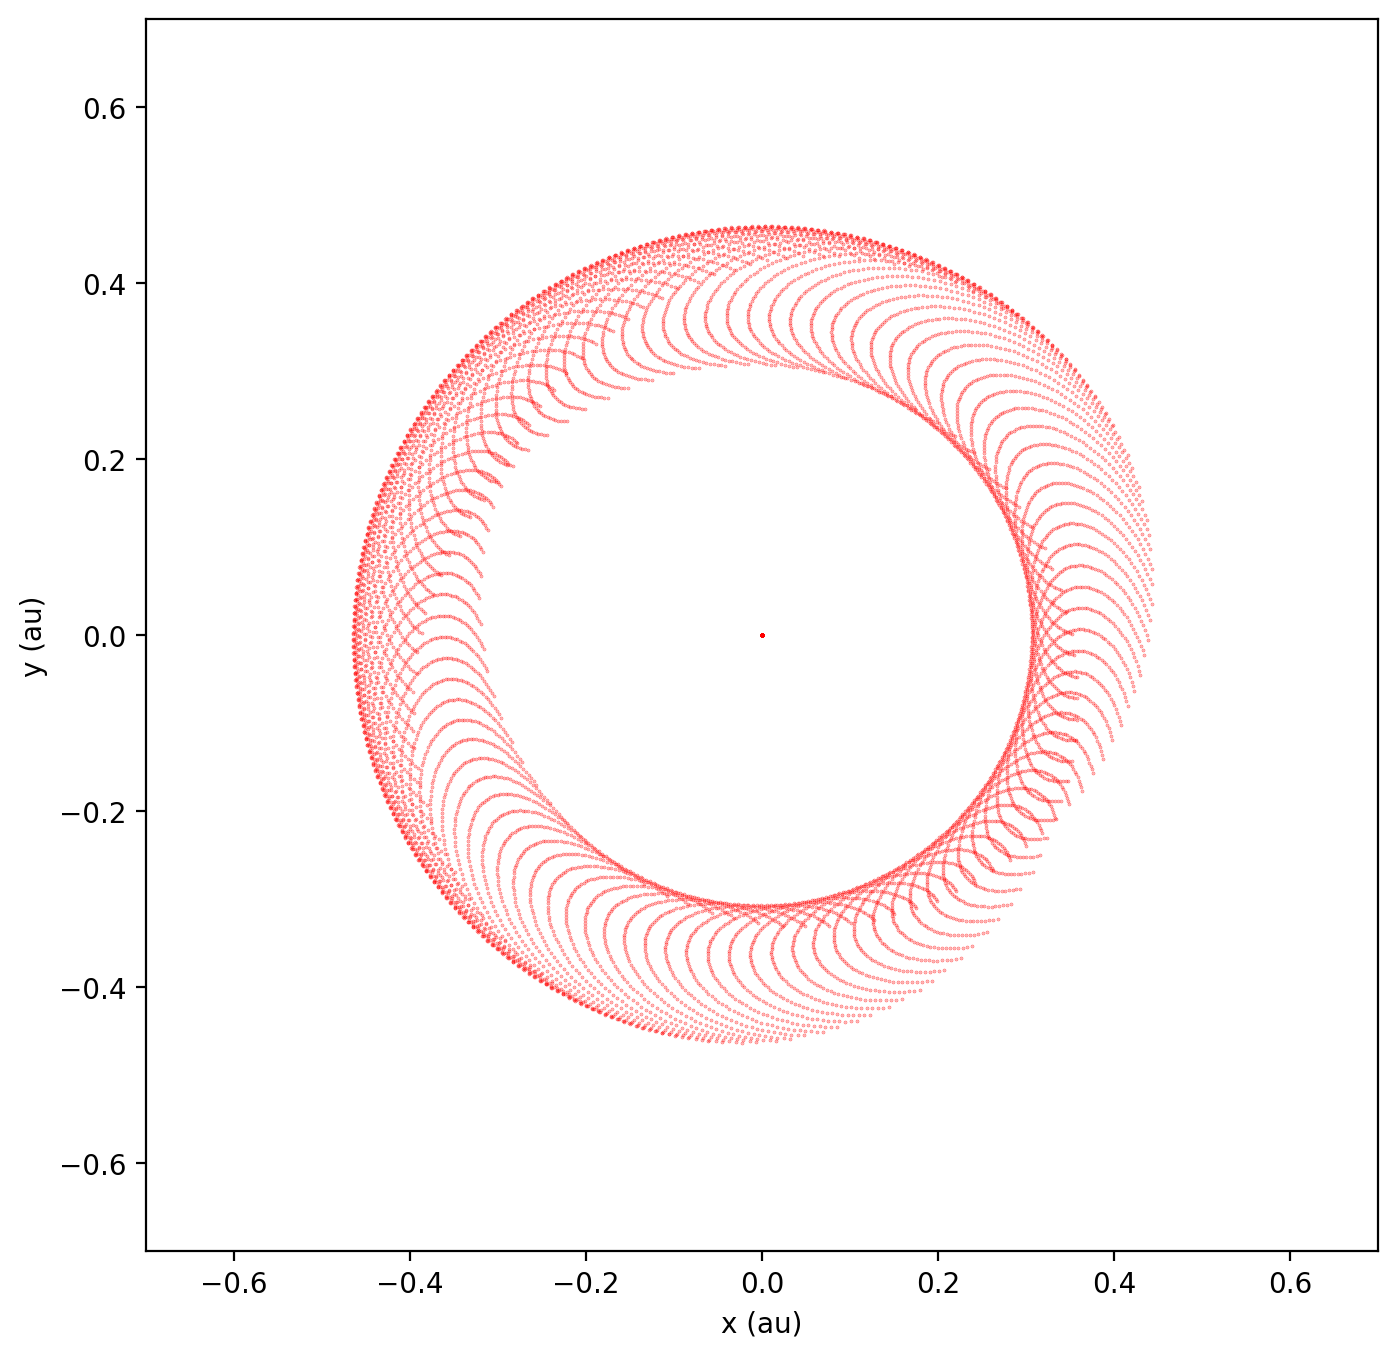

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(px, py, s=0.1, alpha=0.5, color='red')
ax.set_aspect('equal')
ax.set_xlabel("x (au)")
ax.set_ylabel("y (au)")
ax.set_xlim(-0.7, 0.7)
ax.set_ylim(-0.7, 0.7)

In [17]:
import rebound

In [45]:
sim = rebound.Simulation()
sim.units = ('day', 'au', 'Msun')
sim.integrator = 'leapfrog'
sim.t = epochs[0]
sim.dt = 0.1

sim.add(m=1)
sim.add(m=1.6601141530543488e-07, a=0.38635162660475975, e=0.205630, inc=7.00487, Omega=48.33167, omega=77.45645, f=252.25084)
sim.move_to_com()

In [46]:
varpis = []
xs = []
ys = []

sun_xs, sun_ys = [], []
for epoch in epochs:
    sim.integrate(epoch)
    varpis.append(sim.particles[1].pomega)
    xs.append(sim.particles[1].x)
    ys.append(sim.particles[1].y)

    sun_xs.append(sim.particles[0].x)
    sun_ys.append(sim.particles[0].y)



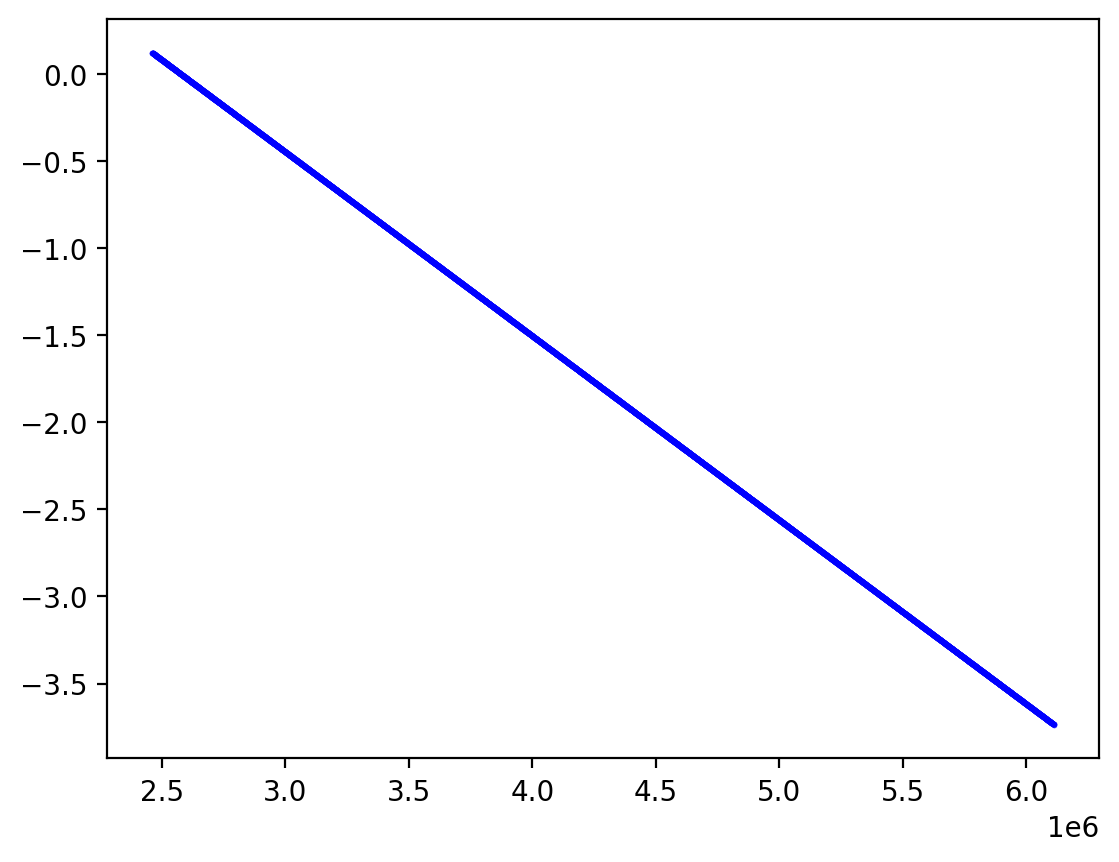

In [47]:
plt.scatter(epochs[:len(varpis)], varpis, s=1, alpha=0.5, label='Rebound', color='blue')

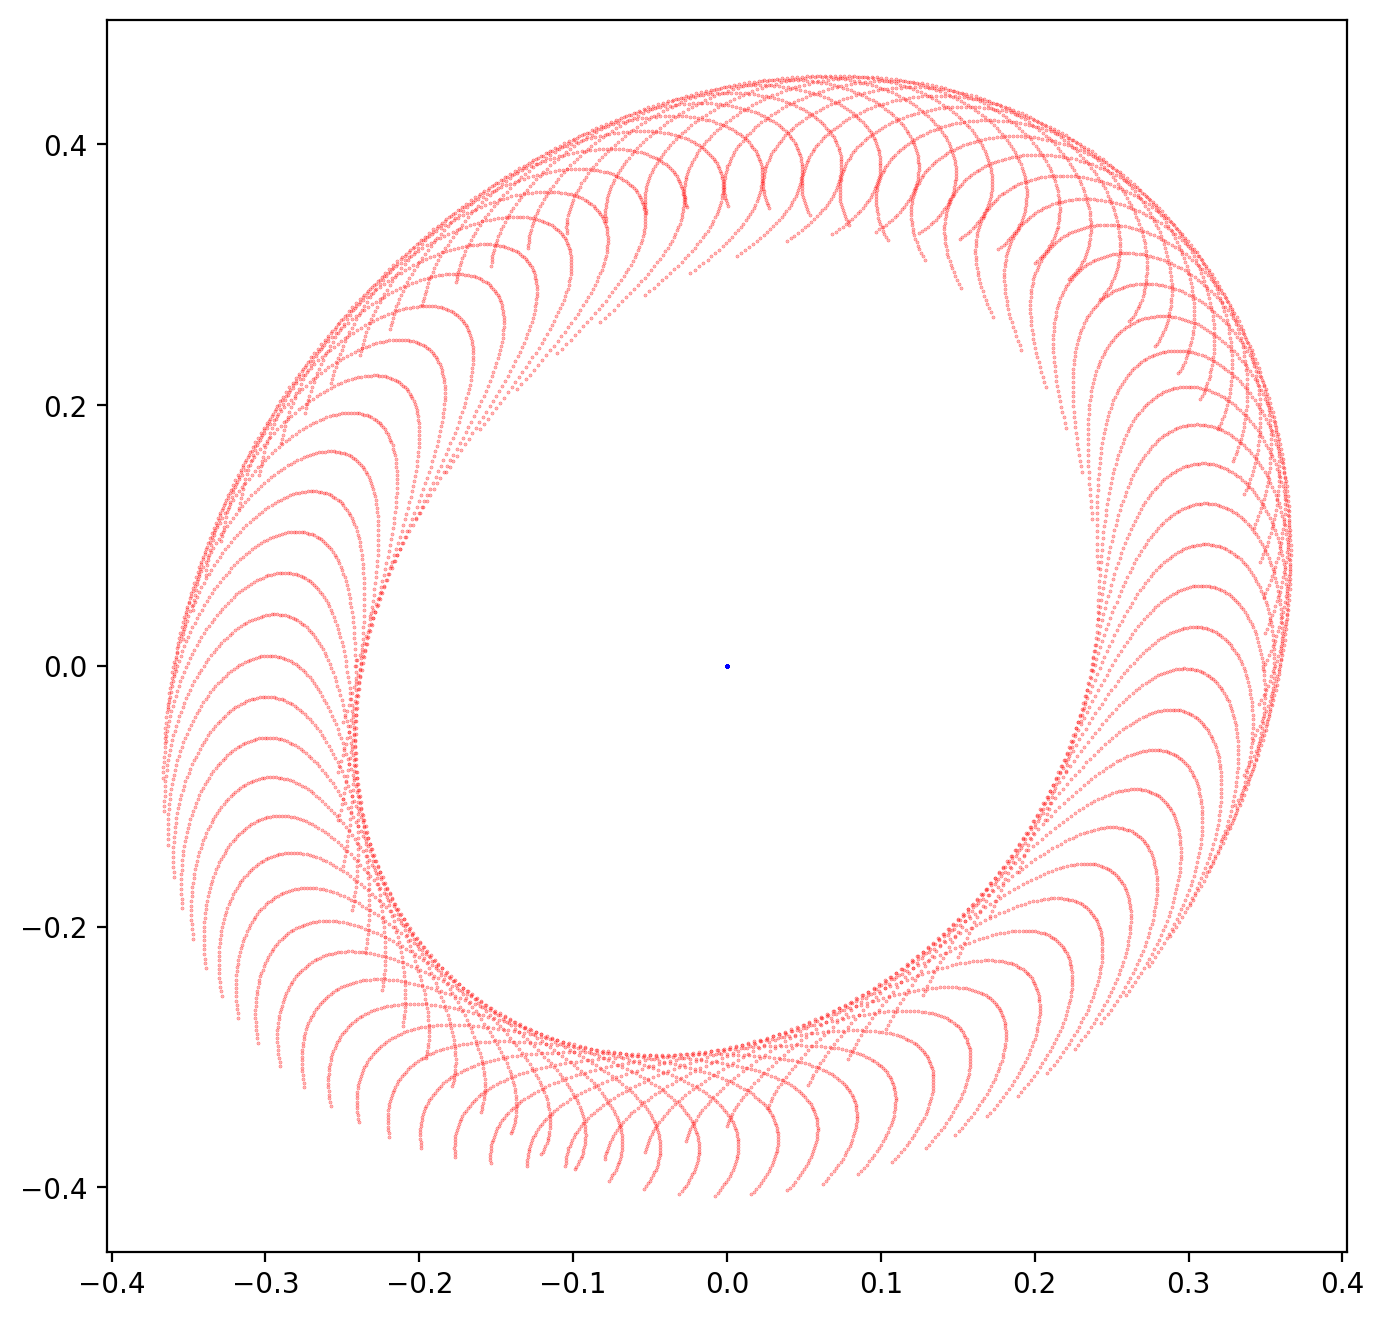

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sun_xs, sun_ys, s=0.1, alpha=0.5, color='blue')
ax.scatter(xs, ys, s=0.1, alpha=0.5, color='red')